In [1]:
%matplotlib inline

In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import sklearn.linear_model
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict, OrderedDict
import tabulate
import time
import GPy
import glob
from functools import reduce
from IPython.display import display
import filterpy
import torch

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

In [3]:
from sklearn import datasets
(moon_x, moon_y) = datasets.make_moons(n_samples=10000, noise=0.05, random_state=42)
(circle_x, circle_y) = datasets.make_circles(n_samples=10000, noise=0.025, random_state=42)

In [4]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class MoonNet(nn.Module):
    def __init__(self):
        super(MoonNet, self).__init__()
        self.hidden = nn.Linear(2, 10)
        self.output = nn.Linear(10, 2)
        
    def forward(self, input):
        x = F.relu(self.hidden(input))
        x = self.output(x)
        return x
    

In [5]:
mn = MoonNet()
var = Variable(torch.from_numpy(moon_x[:10]).float())
out = mn(var)
target = Variable(torch.from_numpy(moon_y[:10]).long())
loss_fn = nn.CrossEntropyLoss()  # LogSoftmax + ClassNLL Loss
err = loss_fn(out, target)
err.backward()

print(err)

Variable containing:
 0.7028
[torch.FloatTensor of size 1]



## Moons dataset

In [6]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 10000, 2, 10, 2

# Create random Tensors to hold inputs and outputs, and wrap them in Variables.
x = Variable(torch.from_numpy(moon_x).float())
y = Variable(torch.from_numpy(moon_y).long(), requires_grad=False)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Variables for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(1000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if 0 == t % 100:
        print(t, loss.data[0])

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 0.6654675006866455
100 0.18337766826152802
200 0.043255310505628586
300 0.01855013519525528
400 0.01128766406327486
500 0.00798196904361248
600 0.006126896478235722
700 0.004951371345669031
800 0.00414235470816493
900 0.003553683403879404


In [7]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 10000, 2, 10, 2

# Create random Tensors to hold inputs and outputs, and wrap them in Variables.
x = Variable(torch.from_numpy(moon_x).float())
y = Variable(torch.from_numpy(moon_y).long(), requires_grad=False)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Variables for its weight and bias.
model_with_reg = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1
decay = 0.01
optimizer_with_reg = torch.optim.SGD(model_with_reg.parameters(), lr=learning_rate, weight_decay=decay)
for t in range(1000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model_with_reg(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if 0 == t % 100:
        print(t, loss.data[0])

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer_with_reg.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer_with_reg.step()

0 0.6797047853469849
100 0.21748247742652893
200 0.19085301458835602
300 0.15700934827327728
400 0.14094054698944092
500 0.13566991686820984
600 0.13406631350517273
700 0.13356760144233704
800 0.13339181244373322
900 0.1333322674036026


Text(0.5,1,'With regularization')

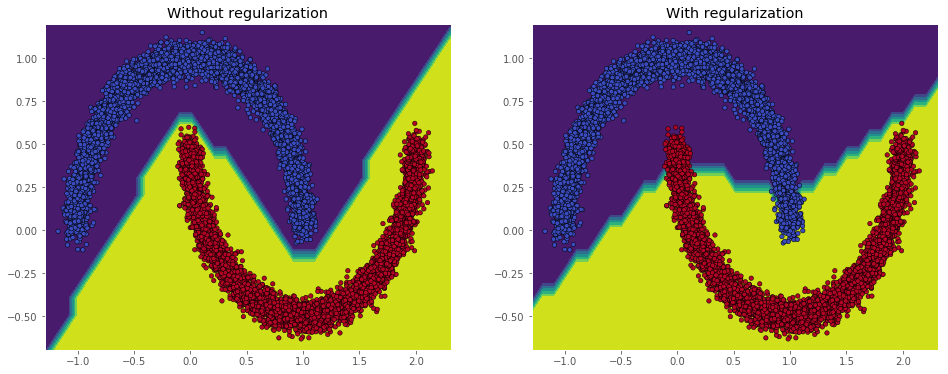

In [8]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() * 1.1, x.max() * 1.1
    y_min, y_max = y.min() * 1.1, y.max() * 1.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, model, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = model(Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()))
    pred = np.argmax(Z.data.numpy(), axis=1)
    pred = pred.reshape(xx.shape)
    out = ax.contourf(xx, yy, pred, **params)
    return out

x = moon_x[:,0]
y = moon_x[:,1]
xx, yy = make_meshgrid(x, y, h=0.1)

fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, hspace=0.7)

ax1 = plt.subplot(gs[0, 0])
plot_contours(ax1, model, xx, yy)
ax1.scatter(x, y, c=moon_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax1.set_title('Without regularization')

ax2 = plt.subplot(gs[0, 1])
plot_contours(ax2, model_with_reg, xx, yy)
ax2.scatter(x, y, c=moon_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax2.set_title('With regularization')

## Circles dataset

In [9]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 10000, 2, 10, 2

# Create random Tensors to hold inputs and outputs, and wrap them in Variables.
x = Variable(torch.from_numpy(circle_x).float())
y = Variable(torch.from_numpy(circle_y).long(), requires_grad=False)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Variables for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(1000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if 0 == t % 100:
        print(t, loss.data[0])

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 0.7139888405799866
100 0.5785389542579651
200 0.4119298756122589
300 0.18112869560718536
400 0.1034528911113739
500 0.06665485352277756
600 0.04464066028594971
700 0.03265363723039627
800 0.025583110749721527
900 0.02099638432264328


In [10]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 10000, 2, 10, 2

# Create random Tensors to hold inputs and outputs, and wrap them in Variables.
x = Variable(torch.from_numpy(circle_x).float())
y = Variable(torch.from_numpy(circle_y).long(), requires_grad=False)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Variables for its weight and bias.
model_with_reg = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1
decay = 0.001
optimizer_with_reg = torch.optim.SGD(model_with_reg.parameters(), lr=learning_rate, weight_decay=decay)
for t in range(1000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model_with_reg(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if 0 == t % 100:
        print(t, loss.data[0])

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer_with_reg.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer_with_reg.step()

0 0.7090938091278076
100 0.4844990372657776
200 0.35902783274650574
300 0.14323914051055908
400 0.0940319374203682
500 3.9346401691436768
600 0.07617715746164322
700 0.06737937033176422
800 0.060513127595186234
900 0.05484356731176376


Text(0.5,1,'With regularization')

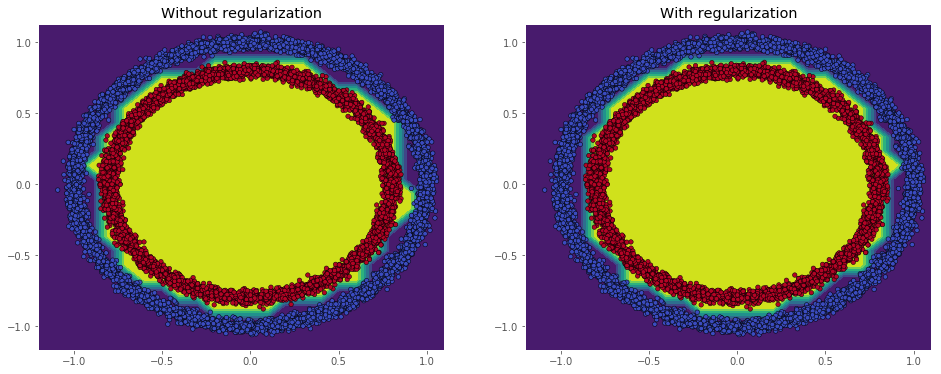

In [11]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() * 1.1, x.max() * 1.1
    y_min, y_max = y.min() * 1.1, y.max() * 1.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, model, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = model(Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()))
    pred = np.argmax(Z.data.numpy(), axis=1)
    pred = pred.reshape(xx.shape)
    out = ax.contourf(xx, yy, pred, **params)
    return out

x = circle_x[:,0]
y = circle_x[:,1]
xx, yy = make_meshgrid(x, y, h=0.1)

fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, hspace=0.7)

ax1 = plt.subplot(gs[0, 0])
plot_contours(ax1, model, xx, yy)
ax1.scatter(x, y, c=circle_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax1.set_title('Without regularization')

ax2 = plt.subplot(gs[0, 1])
plot_contours(ax2, model_with_reg, xx, yy)
ax2.scatter(x, y, c=circle_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax2.set_title('With regularization')